In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm

In [7]:
tickers = [
    "IWDA.AS",
    "IEMA.AS",
    "CSPX.AS"
]

start = "2015-01-01"

In [9]:
data = yf.download(tickers, start=start, progress=False)

print("Top-level columns:", data.columns)

# If data has a column level like ('Close','IWDA.AS'), handle it.
if isinstance(data.columns, pd.MultiIndex):
    # Prefer Adj Close if it exists, otherwise use Close
    fields = data.columns.get_level_values(0).unique().tolist()
    field = "Adj Close" if "Adj Close" in fields else "Close"
    px = data[field].copy()
else:
    # Single-index columns case
    px = data["Adj Close"].copy() if "Adj Close" in data.columns else data["Close"].copy()

# Clean: drop tickers with no data
px = px.dropna(axis=1, how="all")

print("Tickers that worked:", list(px.columns))
px.tail()

Top-level columns: MultiIndex([( 'Close', 'CSPX.AS'),
            ( 'Close', 'IEMA.AS'),
            ( 'Close', 'IWDA.AS'),
            (  'High', 'CSPX.AS'),
            (  'High', 'IEMA.AS'),
            (  'High', 'IWDA.AS'),
            (   'Low', 'CSPX.AS'),
            (   'Low', 'IEMA.AS'),
            (   'Low', 'IWDA.AS'),
            (  'Open', 'CSPX.AS'),
            (  'Open', 'IEMA.AS'),
            (  'Open', 'IWDA.AS'),
            ('Volume', 'CSPX.AS'),
            ('Volume', 'IEMA.AS'),
            ('Volume', 'IWDA.AS')],
           names=['Price', 'Ticker'])
Tickers that worked: ['CSPX.AS', 'IEMA.AS', 'IWDA.AS']


Ticker,CSPX.AS,IEMA.AS,IWDA.AS
Date,,,
2026-02-18,626.572998,49.709999,113.535004
2026-02-19,626.169983,49.459999,113.385002
2026-02-20,627.127991,50.285000,113.669998
2026-02-23,622.179993,50.000000,112.919998
2026-02-24,625.419006,50.834999,113.375000


In [11]:
px_m = px.resample("ME").last()
rets = px_m.pct_change().dropna()

px_m.tail(), rets.tail()

(Ticker         CSPX.AS    IEMA.AS     IWDA.AS
 Date                                         
 2025-10-31  634.362976  45.095001  111.785004
 2025-11-30  631.075989  44.139999  111.400002
 2025-12-31  628.531982  44.584999  111.529999
 2026-01-31  625.982971  47.794998  112.190002
 2026-02-28  625.419006  50.834999  113.375000,
 Ticker       CSPX.AS   IEMA.AS   IWDA.AS
 Date                                    
 2025-10-31  0.047182  0.057947  0.042576
 2025-11-30 -0.005182 -0.021178 -0.003444
 2025-12-31 -0.004031  0.010082  0.001167
 2026-01-31 -0.004055  0.071997  0.005918
 2026-02-28 -0.000901  0.063605  0.010562)

In [12]:
trail_ret_12_1 = (px_m.shift(1) / px_m.shift(12)) - 1
signal = (trail_ret_12_1 > 0).astype(float)

signal.tail()

Ticker,CSPX.AS,IEMA.AS,IWDA.AS
Date,,,
2025-10-31,1.0,1.0,1.0
2025-11-30,1.0,1.0,1.0
2025-12-31,1.0,1.0,1.0
2026-01-31,1.0,1.0,1.0
2026-02-28,1.0,1.0,1.0


In [13]:
w = signal.copy()
row_sum = w.sum(axis=1).replace(0, np.nan)
w = w.div(row_sum, axis=0).fillna(0.0)

w.tail()

Ticker,CSPX.AS,IEMA.AS,IWDA.AS
Date,,,
2025-10-31,0.333333,0.333333,0.333333
2025-11-30,0.333333,0.333333,0.333333
2025-12-31,0.333333,0.333333,0.333333
2026-01-31,0.333333,0.333333,0.333333
2026-02-28,0.333333,0.333333,0.333333


In [14]:
cost_bps = 10  # 10 basis points transaction cost

# Use weights from previous month
w_lag = w.shift(1).fillna(0.0)

# Portfolio returns
gross = (w_lag * rets).sum(axis=1)

# Turnover calculation
turnover = (w_lag.sub(w_lag.shift(1).fillna(0.0)).abs().sum(axis=1)) / 2.0

# Transaction cost
cost = turnover * (cost_bps / 10000.0)

# Net returns
net = gross - cost

bt = pd.DataFrame({
    "gross": gross,
    "net": net,
    "turnover": turnover
}).dropna()

bt.tail()

,gross,net,turnover
Date,,,
2025-10-31,0.049235,0.049235,0.0
2025-11-30,-0.009934,-0.009934,0.0
2025-12-31,0.002406,0.002406,0.0
2026-01-31,0.024620,0.024620,0.0
2026-02-28,0.024422,0.024422,0.0


In [15]:
bench = rets["IWDA.AS"].reindex(bt.index)

eqw_hold = rets.mean(axis=1).reindex(bt.index)

In [16]:
def ann_return(r):
    return (1+r).prod() ** (12/len(r)) - 1

def ann_vol(r):
    return r.std() * np.sqrt(12)

def sharpe(r):
    return (r.mean()/r.std()) * np.sqrt(12)

def max_dd(r):
    eq = (1+r).cumprod()
    peak = eq.cummax()
    dd = eq/peak - 1
    return dd.min()

def capm_alpha_beta(strategy, market):

    df = pd.concat([strategy, market], axis=1).dropna()

    y = df.iloc[:,0]
    x = sm.add_constant(df.iloc[:,1])

    res = sm.OLS(y, x).fit()

    alpha = res.params["const"] * 12
    beta = res.params[df.columns[1]]

    return alpha, beta


metrics = pd.DataFrame({

"Ann Return":[
ann_return(bt["net"]),
ann_return(bench),
ann_return(eqw_hold)
],

"Ann Vol":[
ann_vol(bt["net"]),
ann_vol(bench),
ann_vol(eqw_hold)
],

"Sharpe":[
sharpe(bt["net"]),
sharpe(bench),
sharpe(eqw_hold)
],

"Max Drawdown":[
max_dd(bt["net"]),
max_dd(bench),
max_dd(eqw_hold)
]

},

index=[
"Momentum Strategy",
"IWDA Buy Hold",
"Equal Weight"
])

alpha,beta = capm_alpha_beta(bt["net"],bench)

metrics["Alpha"]=[alpha,None,None]
metrics["Beta"]=[beta,None,None]

metrics

,Ann Return,Ann Vol,Sharpe,Max Drawdown,Alpha,Beta
Momentum Strategy,0.098792,0.115032,0.879290,-0.183794,0.0188,0.738921
IWDA Buy Hold,0.107892,0.133002,0.845629,-0.186100,NaN,NaN
Equal Weight,0.102329,0.125454,0.848229,-0.183794,NaN,NaN


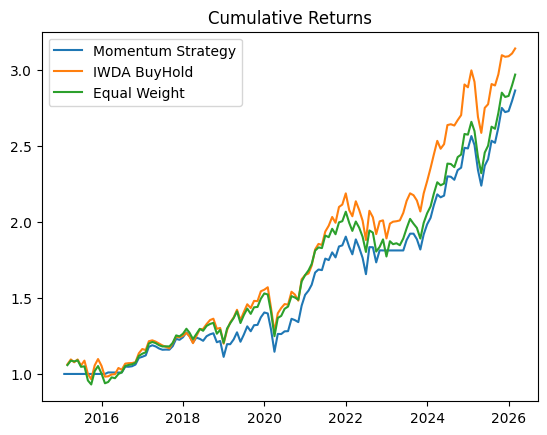

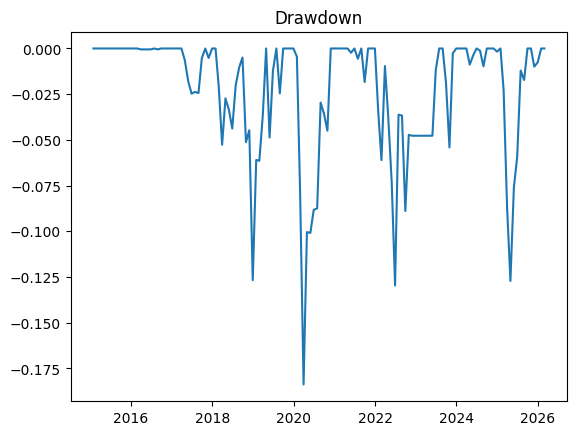

In [19]:
import os

os.makedirs("../gs-quant-etf-momentum/outputs/figures",exist_ok=True)
os.makedirs("../gs-quant-etf-momentum/outputs/tables",exist_ok=True)

def equity(r):
    return (1+r).cumprod()

plt.figure()

plt.plot(equity(bt["net"]),label="Momentum Strategy")
plt.plot(equity(bench),label="IWDA BuyHold")
plt.plot(equity(eqw_hold),label="Equal Weight")

plt.legend()
plt.title("Cumulative Returns")

plt.savefig("../gs-quant-etf-momentum/outputs/figures/cumulative_returns.png")

plt.show()



eq=equity(bt["net"])
peak=eq.cummax()
dd=eq/peak-1

plt.figure()

plt.plot(dd)

plt.title("Drawdown")

plt.savefig("../gs-quant-etf-momentum/outputs/figures/drawdown.png")

plt.show()



metrics.to_csv("../gs-quant-etf-momentum/outputs/tables/performance_metrics.csv")